In [185]:
pip install fastai==0.7.0

In [0]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [187]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd

In [0]:
data=pd.read_csv("/content/drive/My Drive/ML dataSets/titanic/train.csv",encoding = "ISO-8859-1")

In [190]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [191]:
data.shape

(891, 12)

In [192]:
for i in data.columns:
  print(i,data[i].dtype)

PassengerId int64
Survived int64
Pclass int64
Name object
Sex object
Age float64
SibSp int64
Parch int64
Ticket object
Fare float64
Cabin object
Embarked object


## We will do data engineering

We will convert non integer columns to numeric columns

In [0]:
train_cats(data)
# it makes all the string column as categorical column

In [194]:
for i in data.columns:
  print(i,data[i].dtype)

PassengerId int64
Survived int64
Pclass int64
Name category
Sex category
Age float64
SibSp int64
Parch int64
Ticket category
Fare float64
Cabin category
Embarked category


So now u can see that all the string based columns have been converted to categorical features

In [195]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


U can also see that train_cats hasn't changed the data frame at all, all it has done is that it has changed the data type from string to categorical

In [196]:
data.Embarked.cat.categories

Index(['C', 'Q', 'S'], dtype='object')

Embarked columns has been categorised, earlier it was an object

In [0]:
# m = RandomForestRegressor(n_jobs=-1)
# # The following code is supposed to fail due to string values in the input data
# m.fit(data.drop('Survived', axis=1), data.Survived)

# This would give could not convert string to float: 'Braund, Mr. Owen Harris', because what all ML models expect is numeric dataset, but here we have categories, in which we have string data
# and string cannot be converted to float is the error

In [198]:
len(data.Name.cat.categories)

891

proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column

In [0]:
df, y, nas = proc_df(data, 'Survived')

In [200]:
df.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_na'],
      dtype='object')

In [201]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
0,1,3,109,2,22.0,1,0,524,7.2500,0,3,False
1,2,1,191,1,38.0,1,0,597,71.2833,82,1,False
2,3,3,354,1,26.0,0,0,670,7.9250,0,3,False
3,4,1,273,1,35.0,1,0,50,53.1000,56,3,False
4,5,3,16,2,35.0,0,0,473,8.0500,0,3,False


U can see that Name also have been numericalised, so this function is amazing

In [202]:
m=RandomForestClassifier(n_jobs=-1)
m.fit(df,y)
m.score(df,y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9820426487093153

So we have a training score of 98%

## What each tree is doing

What if I have only One tree

In [203]:
m=RandomForestClassifier(n_jobs=-1,n_estimators=1,bootstrap=False)
m.fit(df,y)
m.score(df,y)

1.0

In [204]:
!pip install IPython

In [0]:
import IPython
import graphviz
# from sklearn.tree import graphviz
from sklearn.tree import export_graphviz
from IPython.display import display

## Solve this issue

Of not able to plot the tree

In [206]:
draw_tree(m.estimators_[0],df,precision=3)

NameError: ignored

#Observation

We have seen that single tree is performing much better, than ensemble

But we havn't tested it against validation set, since we have small dataset, we can't have validation dataset, and luckily for Random forest, we dont need validation set, we can use OBB score


## OR lets say

Have some validation set, of 200 rows, so that we can play around and so some tweaks

It is important to make good validation set, otherwise we end up with wrong results

In [207]:
threshold=(100/len(df))*200
print(threshold)

22.44668911335578


In [0]:
# let take 78% data into train and 22% in validation, let us do it randomly becoz timestamp dont play a huge role here
from sklearn.model_selection import train_test_split
def_train, def_val,y_train, y_val=train_test_split(df,y,test_size=0.22,random_state=77)

In [209]:
print(def_train.shape)
print(def_val.shape)

(694, 12)
(197, 12)


Now we are good to go and now we will train the model, and then tune the parameters accordingly

In [210]:
m=RandomForestClassifier(n_estimators=10)
m.fit(def_train,y_train)
print('the training score is ',m.score(def_train,y_train))
print('the val score is ',m.score(def_val,y_val))

the training score is  0.9855907780979827
the val score is  0.8121827411167513


It seems we are overfitting the data because, we have val_score very less as compared to the training error

Or may turn out that our validation set is  not good, well so good case, let us say we have good validation set, and now we are get better validation score

We can do so in many ways, One way is that we can tune certain hyper parameters, like : 

###min_sample_leaf,which would affect the height of the tree and would reduce the overfitting

###max_feature which would do sampling of the columns, and thus each tree in forestg would have different properties and prediction power

###other way is by enabling boostraping as True, by default bootstrap is True

Try out increasing the number of tree also

In [211]:
val_score_list=[]
estimators_list=[]
for i in [20,30,40,50,60,100,120]:
  m=RandomForestClassifier(n_estimators=i,bootstrap=False)
  m.fit(def_train,y_train)
  print('when estimators are ',i)
  p=m.score(def_train,y_train)
  print('training score is ',p)
  q=m.score(def_val,y_val)
  print('validation score is ',q)
  print()
  val_score_list.append(q)
  estimators_list.append(i)

when estimators are  20
training score is  1.0
validation score is  0.8375634517766497

when estimators are  30
training score is  1.0
validation score is  0.8426395939086294

when estimators are  40
training score is  1.0
validation score is  0.8121827411167513

when estimators are  50
training score is  1.0
validation score is  0.8274111675126904

when estimators are  60
training score is  1.0
validation score is  0.8274111675126904

when estimators are  100
training score is  1.0
validation score is  0.8375634517766497

when estimators are  120
training score is  1.0
validation score is  0.8324873096446701



In [0]:
import matplotlib.pyplot as plt

In [0]:
??plt.plot()

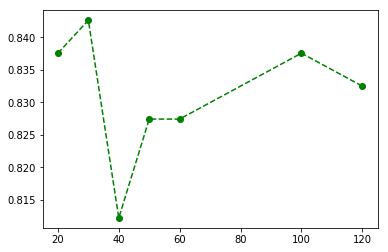

In [214]:
plt.plot(estimators_list,val_score_list,'go--')

## Observation

Given that boostraping is False
We just plotted that val score became almost flat, no improvement

We are terribly overfitting the data, as we have val score as 1, and getting low val score

## Lets tune others parameters

## Bootstraping


Let us try bootstraping, which says that instead of taking whole dataset for training we take only a few rows(subset with replacement ) and train each  tree, and in such a way we have different trees and we can get better Random Forest Model

Since we are using only subset of data to train each tree, thus remaining rows act as validation set for that tree, thus each tree has its validation set, and we can have OBB score in case of bootstrap is true

How OBB score is calculated is as follows, for each row, let us say row A, we see, in whose validation set this row A falls and all those trees predict the value of row A, and we take the average of all these predictions as final prediction of row A.

Same is done for all rows in the dataset, and then these predictions are compared with actual value of y, and OBB score is calculated

OBB score is less promising than validation score. Think Why?

In [215]:
val_score_list=[]
estimators_list=[]
for i in [20,30,40,50,60,100,120]:
  m=RandomForestClassifier(n_estimators=i,bootstrap=True)
  m.fit(def_train,y_train)
  print('when estimators are ',i)
  p=m.score(def_train,y_train)
  print('training score is ',p)
  q=m.score(def_val,y_val)
  print('validation score is ',q)
  print()
  val_score_list.append(q)
  estimators_list.append(i)

when estimators are  20
training score is  0.9956772334293948
validation score is  0.8274111675126904

when estimators are  30
training score is  1.0
validation score is  0.8324873096446701

when estimators are  40
training score is  0.9985590778097982
validation score is  0.8020304568527918

when estimators are  50
training score is  1.0
validation score is  0.8324873096446701

when estimators are  60
training score is  1.0
validation score is  0.7969543147208121

when estimators are  100
training score is  1.0
validation score is  0.8121827411167513

when estimators are  120
training score is  1.0
validation score is  0.8121827411167513



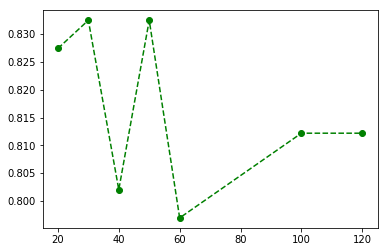

In [216]:
plt.plot(estimators_list,val_score_list,'go--')

Clearly Boostraping is removing the overfit by 0.1 percent, increase in # trees is then again making overfit


##Reason why increase in # trees is increasing overfit?
One possible reason is that as all trees are identical in their decision making, which we can change by max_features

## Tuning min_samples_leaf

By default it is 1

The minimum number of samples required to be at a leaf node.
        A split point at any depth will only be considered if it leaves at
        least ``min_samples_leaf`` training samples in each of the left and
        right branches.  This may have the effect of smoothing the model,
        especially in regression.

In [217]:
val_score_list=[]
estimators_list=[]
for i in [1,2,3,4,5,6,7,8,9,10]:
  m=RandomForestClassifier(min_samples_leaf=i)
  m.fit(def_train,y_train)
  print('when estimators are ',i)
  p=m.score(def_train,y_train)
  print('training score is ',p)
  q=m.score(def_val,y_val)
  print('validation score is ',q)
  print()
  val_score_list.append(q)
  estimators_list.append(i)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

when estimators are  1
training score is  0.9913544668587896
validation score is  0.8324873096446701

when estimators are  2
training score is  0.946685878962536
validation score is  0.8324873096446701

when estimators are  3
training score is  0.9178674351585014
validation score is  0.8071065989847716

when estimators are  4
training score is  0.8962536023054755
validation score is  0.8071065989847716

when estimators are  5
training score is  0.8847262247838616
validation score is  0.8223350253807107

when estimators are  6
training score is  0.8904899135446686
validation score is  0.817258883248731

when estimators are  7
training score is  0.8847262247838616
validation score is  0.8274111675126904

when estimators are  8
training score is  0.877521613832853
validation score is  0.8274111675126904

when estimators are  9
training score is  0.8530259365994236
validation score is  0.8020304568527918

when estimators are  10
training score is  0.8645533141210374
validation score is  0.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


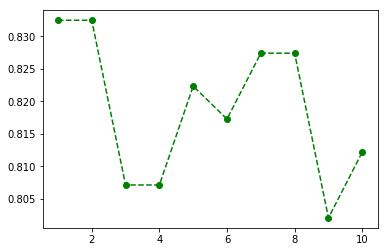

In [218]:
plt.plot(estimators_list,val_score_list,'go--')

## checkpoint
Got highest score of 84% at leaf size of 9

## Tuning the max_feature

The number of features to consider when looking for the best split:


If “auto”, then max_features=sqrt(n_features).

If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).

If “log2”, then max_features=log2(n_features)

In [0]:
from math import sqrt

In [220]:
m=RandomForestClassifier(max_features=9,bootstrap=False)
m.fit(def_train,y_train)
print(m.score(def_train,y_train))
print(m.score(def_val,y_val))

1.0
0.8274111675126904


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


9 max_features is giving us better validation error

## Confidence based on tree variance


We will talk about this later

## Feature Importance

In [221]:
# talking all the best params from above
m=RandomForestClassifier(n_estimators=30,bootstrap=True,min_samples_leaf=9 ,max_features=9)
m.fit(def_train,y_train)
print(m.score(def_train,y_train))
print(m.score(def_val,y_val))

0.8847262247838616
0.817258883248731


Luckily we are not overfitting but have not too good validation score

In [222]:
fi = rf_feat_importance(m, def_train); 
fi

,cols,imp
3,Sex,0.434069
8,Fare,0.110578
1,Pclass,0.095130
7,Ticket,0.094634
9,Cabin,0.070303
4,Age,0.068870
2,Name,0.059434
0,PassengerId,0.041581
6,Parch,0.009910
10,Embarked,0.007770


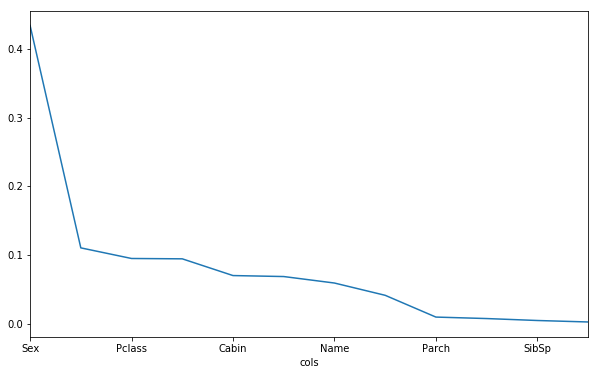

In [223]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

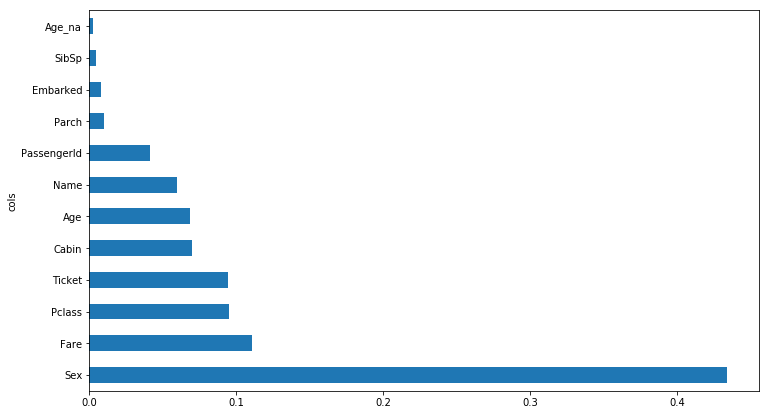

In [225]:
plot_fi(fi[:30]);

Let us try to remove features Age_na, parch,embarked as they contribute very less

In [0]:
to_keep=fi[fi.imp>0.03].cols

In [227]:
to_keep

3            Sex
8           Fare
1         Pclass
7         Ticket
9          Cabin
4            Age
2           Name
0    PassengerId
Name: cols, dtype: object

In [0]:
df_keep_train_x=def_train[to_keep].copy()

#### remember that features in model (which is created with train dataset), must be equal to features in input dataset

In [0]:
def_keep_val=def_val[to_keep].copy()

In [230]:
m=RandomForestClassifier(n_estimators=30,bootstrap=True,min_samples_leaf=9 )
m.fit(df_keep_train_x,y_train)
print(m.score(df_keep_train_x,y_train))
print(m.score(def_keep_val,y_val))

0.8731988472622478
0.8375634517766497


In [231]:
m=RandomForestClassifier()
m.fit(df_keep_train_x,y_train)
print(m.score(df_keep_train_x,y_train))
print(m.score(def_keep_val,y_val))

0.9913544668587896
0.8223350253807107


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [232]:
m=RandomForestClassifier(n_estimators=30)
m.fit(df_keep_train_x,y_train)
print(m.score(df_keep_train_x,y_train))
print(m.score(def_keep_val,y_val))

0.9985590778097982
0.8071065989847716


In [233]:
m=RandomForestClassifier(n_estimators=30,bootstrap=True)
m.fit(df_keep_train_x,y_train)
print(m.score(df_keep_train_x,y_train))
print(m.score(def_keep_val,y_val))

0.9956772334293948
0.8223350253807107


Bootstraping didn't proved to be of any use in above case

## We also know that name also dont play any role in survival, remove that feature some next time

Do it before u write a blog

In [234]:
m=RandomForestClassifier(n_estimators=30,min_samples_leaf=9 )
m.fit(df_keep_train_x,y_train)
print(m.score(df_keep_train_x,y_train))
print(m.score(def_keep_val,y_val))

0.8674351585014409
0.8223350253807107


This is better


##Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [0]:
from scipy.cluster import hierarchy as hc

In [0]:
df_keep=df[to_keep].copy()

In [237]:
df_keep.shape

(891, 8)

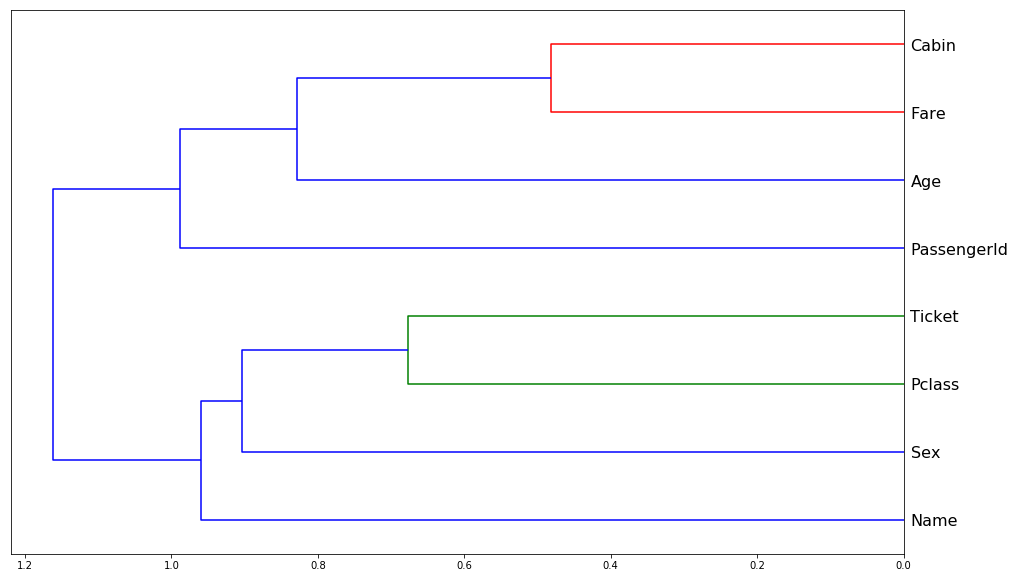

In [238]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

## Results it turned out that no features are redundant, in terms of delivering same performance

In case u dont know about dendrograms, it can be thought as representation of clustering same objects within one cluster, and if objects are more closer than they are clubbed very early

See below image for clarity

https://www.researchgate.net/profile/Atef_Nassar/publication/288480628/figure/fig9/AS:324924200767502@1454479374699/Tree-dendrogram-of-the-clustering-patterns-and-their-proportion-of-explained-variance-13.png

Since we arrived at situation where, we get to know that age plays an important factor in Prediction, 4 times powerful than other features


We can do research why is that and can do EDA

Now this approach is ML driven EDA

## Partial dependency

Let us see what we get in test data set

In [239]:
data=drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
test=pd.read_csv("/content/drive/My Drive/ML dataSets/titanic/test.csv",encoding = "ISO-8859-1")

In [241]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [243]:
test_x=test[to_keep]
test_x.head()

,Sex,Fare,Pclass,Ticket,Cabin,Age,Name,PassengerId
0,male,7.8292,3,330911,NaN,34.5,"Kelly, Mr. James",892
1,female,7.0000,3,363272,NaN,47.0,"Wilkes, Mrs. James (Ellen Needs)",893
2,male,9.6875,2,240276,NaN,62.0,"Myles, Mr. Thomas Francis",894
3,male,8.6625,3,315154,NaN,27.0,"Wirz, Mr. Albert",895
4,female,12.2875,3,3101298,NaN,22.0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",896


## Be cautious we cannot give this data to model, as it is not numericalised

In [257]:
# using train_cats
train_cats(test_x)

/usr/local/lib/python3.6/dist-packages/fastai/structured.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()


In [258]:
df, y, nas = proc_df(test_x)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [259]:
df.head()

,Sex,Fare,Pclass,Ticket,Cabin,Age,Name,PassengerId,Fare_na,Age_na
0,2,7.8292,3,153,0,34.5,207,892,False,False
1,1,7.0000,3,222,0,47.0,404,893,False,False
2,2,9.6875,2,74,0,62.0,270,894,False,False
3,2,8.6625,3,148,0,27.0,409,895,False,False
4,1,12.2875,3,139,0,22.0,179,896,False,False


In [0]:
answer=m.predict(df[to_keep])

In [261]:
answer.shape

(418,)

In [262]:
test.shape

(418, 11)

In [0]:
answer_df=pd.DataFrame(columns=['PassengerId','Survived'])

In [0]:
answer_df['PassengerId']=df['PassengerId']

In [0]:
answer_df['Survived']=answer

In [0]:
answer_df.to_csv('submission.csv', sep='\t')

In [0]:
!cp submission.csv drive/My\ Drive/ML\ dataSets/titanic

## Result

Got 0.75 score in kaggle

Not that bad, we know its gonna happen, let us try Naive bayes which is good for classfication, and SVM